In [90]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [91]:
dataset_filename = 'ML-Python-Lab-Data.csv'
df = pd.read_csv(dataset_filename, index_col=0, header=None, names=['Index', 'Sex','Length', 'Diameter', 'Height', \
    'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'])
# the name were stored in a different file, this is why this information was known. 

target = 'Rings'
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Index,,,,,,,,,
0,M,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0
1,M,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0
2,F,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0
3,M,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0
4,I,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0


We have a dataset without column names and with missing values. 

In [92]:
print("The dataset size is {}".format(df.shape))

The dataset size is (4177, 9)


In [93]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,3997.000000,3976.000000,3987.000000,3990.000000,3983.000000,4002.000000,3990.000000,4177.000000
mean,0.525330,0.408448,0.139669,0.830577,0.360681,0.180995,0.239796,0.861623
std,0.119569,0.098728,0.041988,0.490629,0.221100,0.109425,0.139765,0.762510
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.450000,0.350000,0.115000,0.444500,0.188000,0.094000,0.130000,0.000000
50%,0.545000,0.425000,0.140000,0.802250,0.339000,0.171500,0.235000,1.000000
75%,0.615000,0.480000,0.165000,1.154375,0.503250,0.253500,0.330000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,3.000000


<AxesSubplot:>

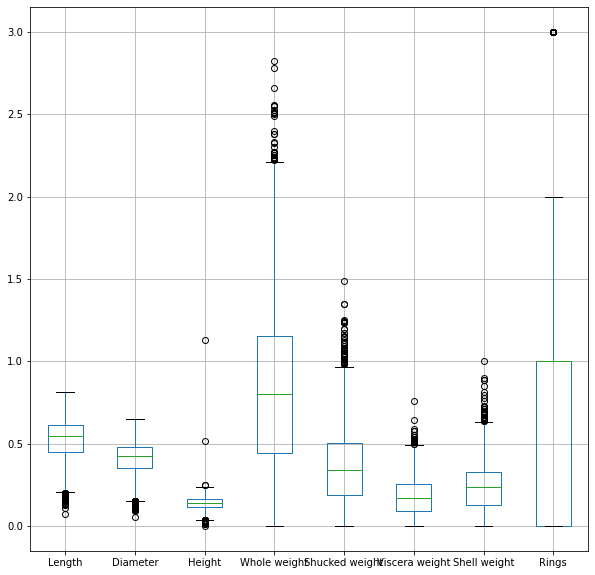

In [94]:
df.boxplot(figsize=(10,10))

The data has very much different domain intervals, particularly in the case of column 5, so we might need to apply a scaling technique.
We also have some outliers in each column, even though column 9 has less outliers. 

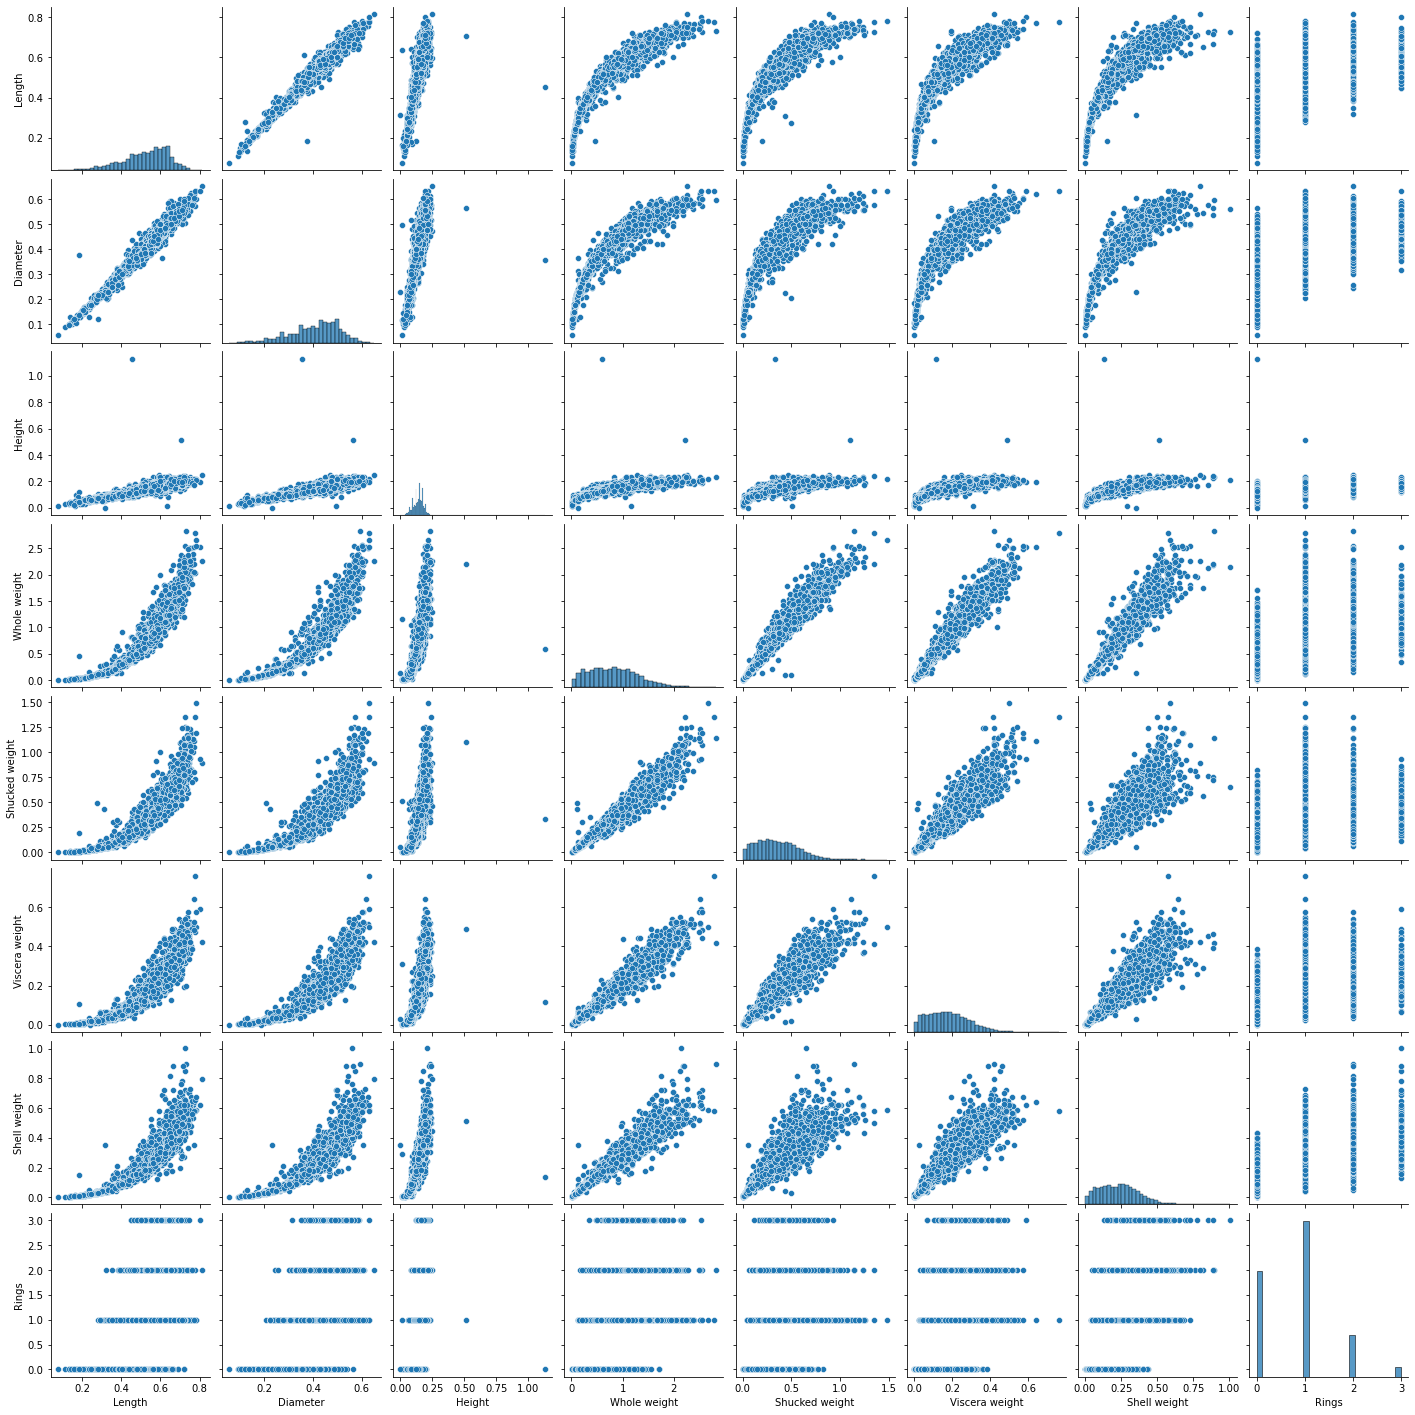

In [95]:
sns.pairplot(df)

As we've mentioned, this dataset has a set of peculiarities. 
- The distributions are not balanced, since the some columns have very different interval ranges w.r.t. the others. 
- Since we have a column with non-numerical values, we may need to apply some kind of value encoding. 
- There are missing values in the dataset. This can be seen in the 'describe' step, in which some columns have less values than others. We may need to drop them.
- The distribution of data can be approximated by a curve for some pairs (i.e., (2,8), (2,5)) and by a line (linear distribution) for some others (i.e. (7,5), (6,5)).
- In the pairplots, we can see the presence of some outliers, since we have some values that are very much far from the others. 


Before dropping any columns, we may first need to transform data properly. First, let's encode the values in the first column using a OrdinalEncoder.  

In [96]:
# from sklearn.preprocessing import OrdinalEncoder
# oe = OrdinalEncoder(dtype=int)
# df0 = df.copy() # df0 is used to make modification to the table.
# column_to_transform = 'Sex' 
# df0[column_to_transform] = oe.fit_transform(df0[column_to_transform].values.reshape(-1,1))
# df0.head()

## The professors prefers a OneHotEnconder, so let's give him that
from sklearn.preprocessing import OneHotEncoder
one = OneHotEncoder()
df0 = df.copy() # df0 is used to make modification to the table.
column_to_transform = 'Sex' 
enc_data = one.fit_transform(df0[[column_to_transform]]).toarray()
l = list(one.categories_[0])
enc_df = pd.DataFrame(one.fit_transform(df0[[column_to_transform]]).toarray(), columns=l)
df = df.join(enc_df)
df0 = df.drop(columns='Sex')
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
Index,,,,,,,,,,,,
0,M,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0,0.0,0.0,1.0
1,M,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0,0.0,0.0,1.0
2,F,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0,1.0,0.0,0.0
3,M,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0,0.0,0.0,1.0
4,I,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0,0.0,1.0,0.0


Now, another important thing to do, is to deal with missing values. 
Simply, we drop them.  

In [98]:
print("There are {} columns with missing values".format(df0.isna().sum().sum()))
df0 = df0.dropna()
df0.head()
print("There are {} columns with missing values".format(df0.isna().sum().sum()))

There are 0 columns with missing values
There are 0 columns with missing values


Let's plot again in order to visualize any changes to our dataset. 

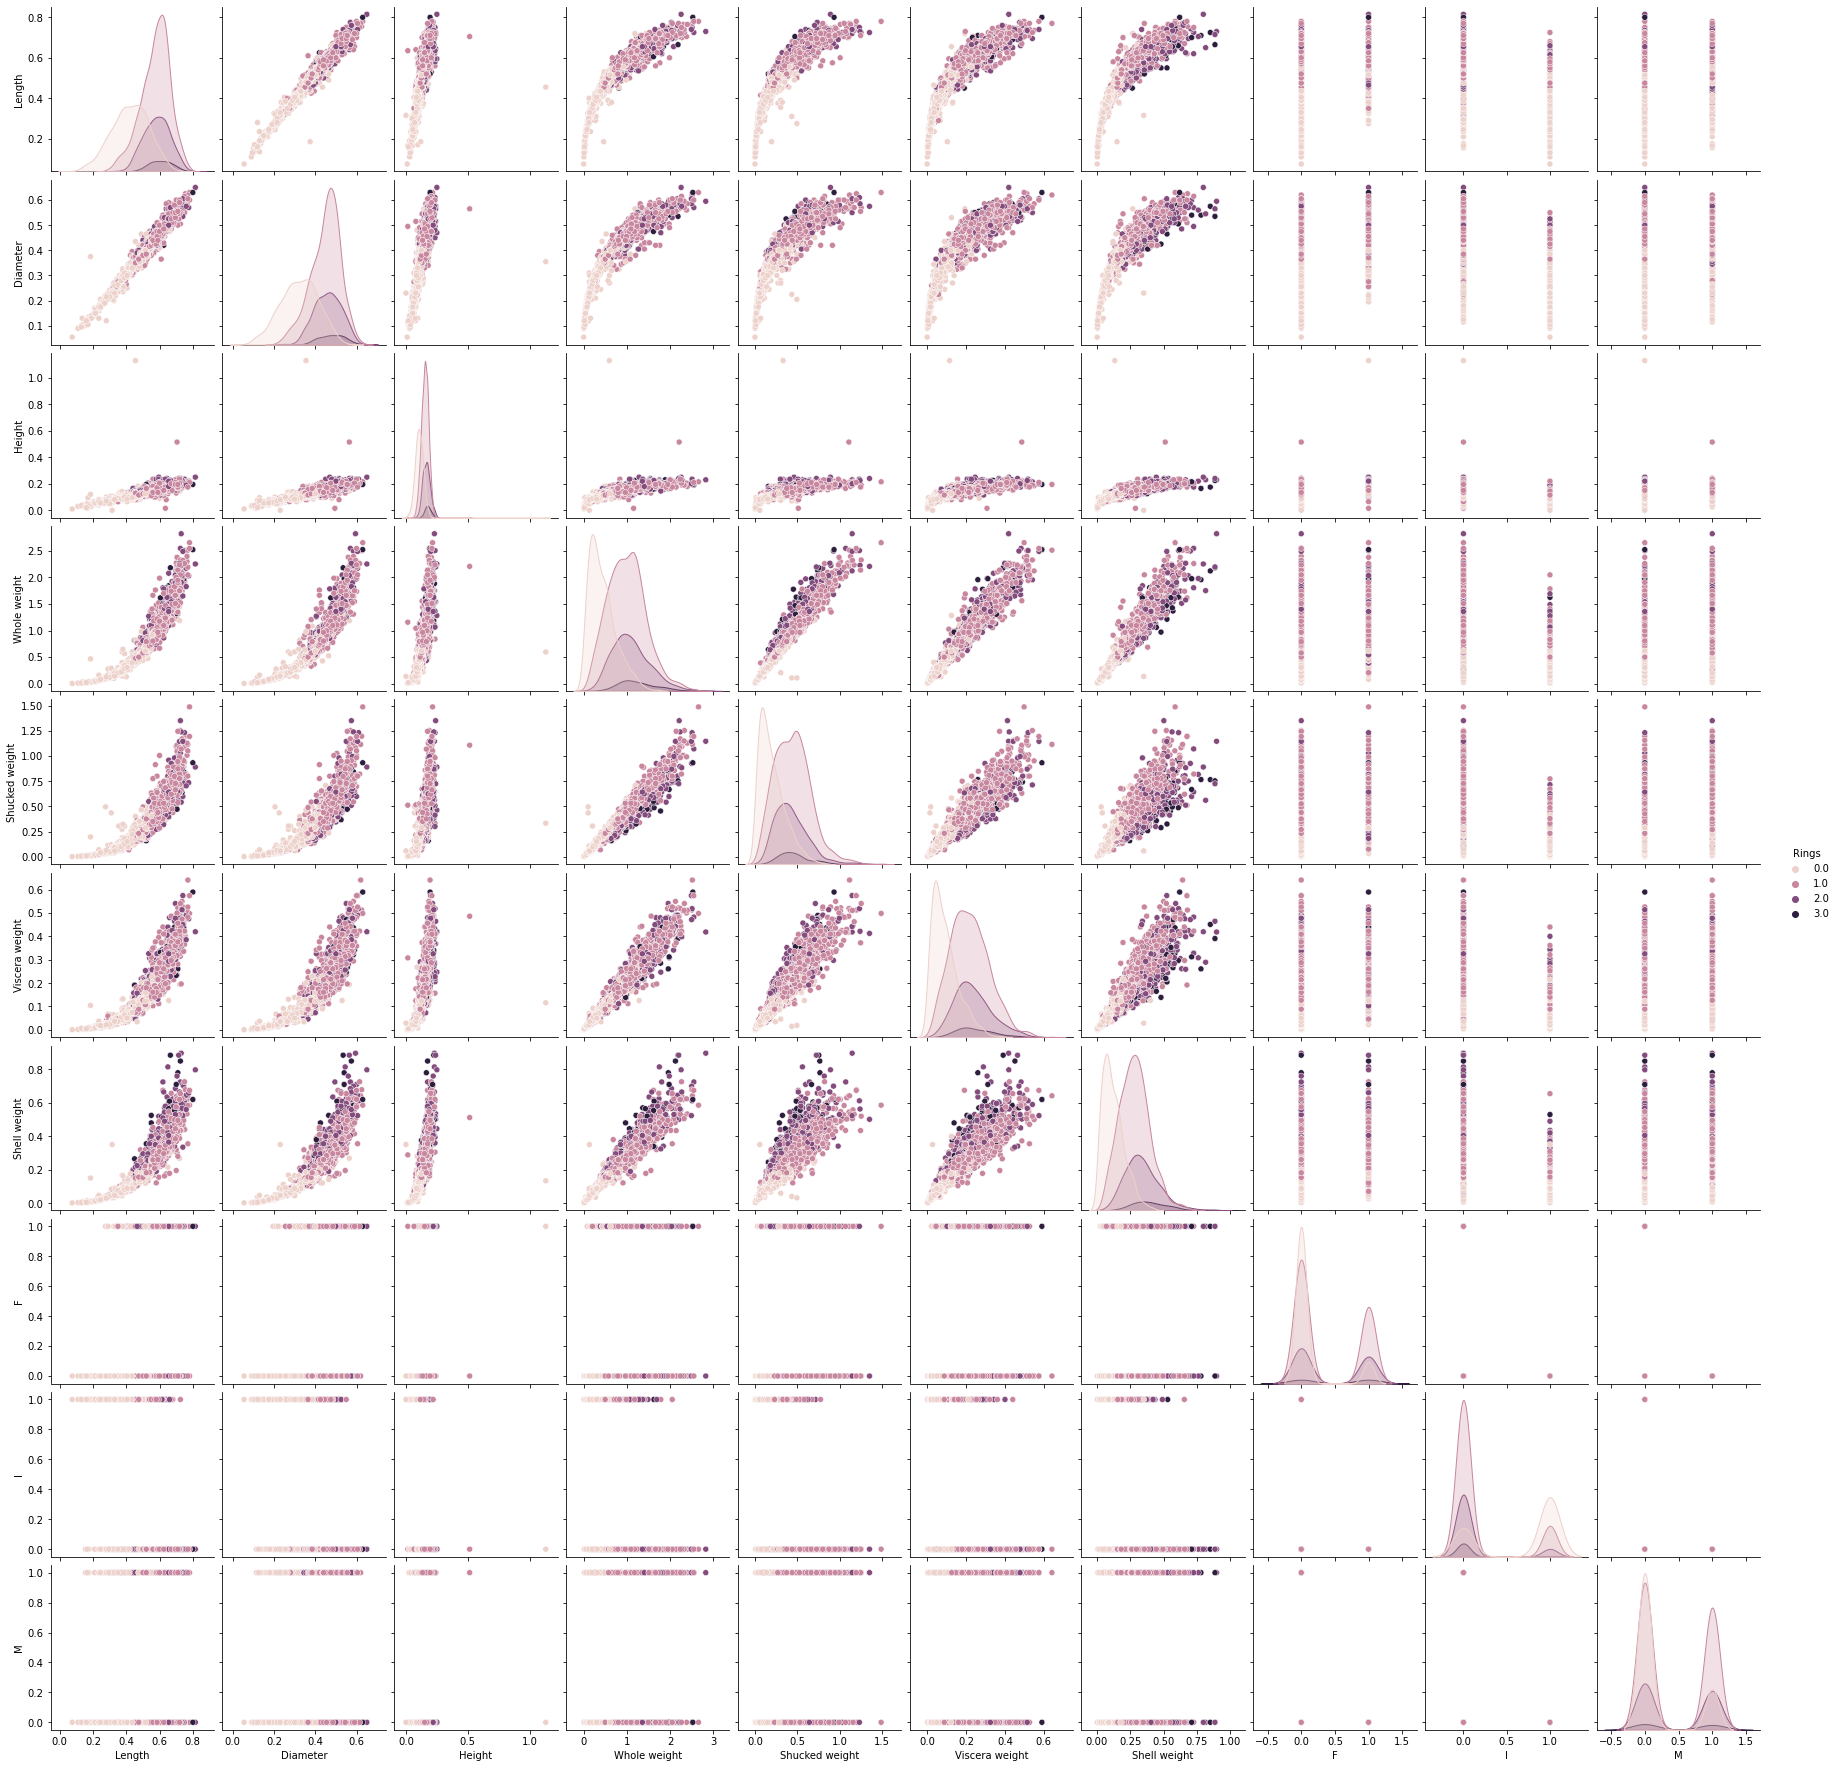

In [99]:
sns.pairplot(df0, hue=target)

Our distributions have not changed after the data transformation operations. 

We can see that many of the columns have very much similar distributions.
This is also evidenced by the fact that the pairplot of these columns has a distribution similar to $y = x$. 

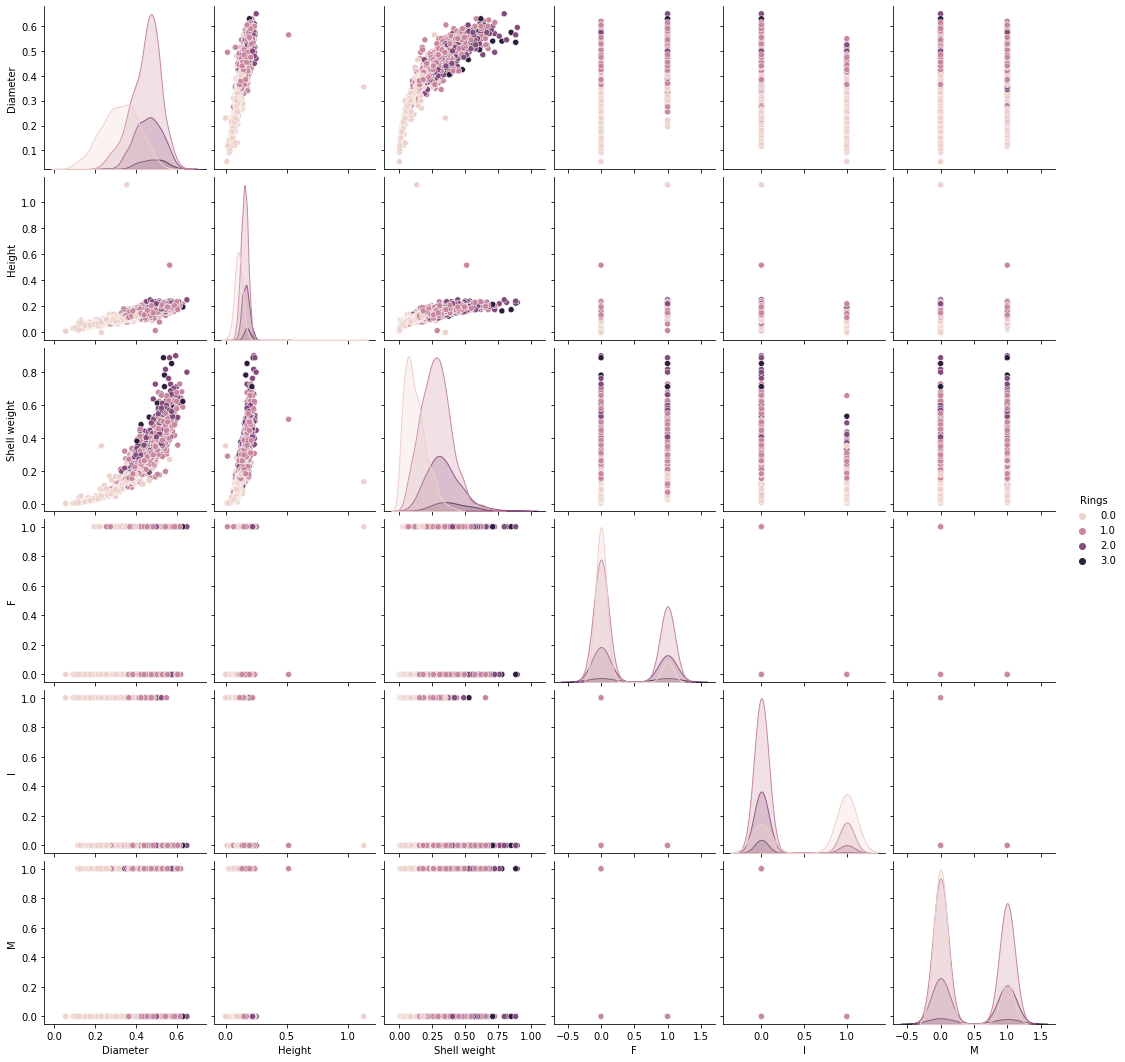

In [100]:
df1 = df0.drop(columns=['Length', 'Whole weight', 'Viscera weight', 'Shucked weight'])
sns.pairplot(df1, hue=target)

The resulting plots have a more varied distribution. 

We now have to find the best classification scheme considering two classification methods, and find the best hyperparameters using CV, the optimization must be focused on the `f1_macro measure`. 

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

model_lbls = [
              'dt', 
             'knn',
            ]

# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,20)]}]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
       },
}

In [102]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df1.drop(columns=target)
y = df1[target]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7)
print("Training on {:} samples".format(Xtrain.shape[0]))

scores = []
estimators = {}

for model in model_lbls: 
    estimator = GridSearchCV(scoring='f1_macro', n_jobs=2, cv=5, # scoring on f1_macro 
        estimator=models[model]['estimator'], param_grid=models[model]['param']) 

    estimator.fit(Xtrain, ytrain)
    estimators[model] = estimator.best_estimator_
    scores.append([model, estimator.best_score_, estimator.best_params_])

result_df = pd.DataFrame(data=scores, columns=['model', 'f1_score', 'params']).sort_values(by='f1_score', ascending=False)
result_df

Training on 2136 samples


,model,f1_score,params
0,dt,0.443967,{'max_depth': 7}
1,knn,0.439541,{'n_neighbors': 10}


In this case, the DT model was the best for the classification, regarding the f1 score. If we repeat the process using the complete dataset, our accuracy score is not that different, meaning that our classifier is still very good. 

Our last task is to compute the performance measures and the confusion matrices of each data.
In order to do that, we'll use this function. 

In [103]:
from sklearn.metrics import confusion_matrix
for model in model_lbls : 
    y_true, y_pred = ytest, estimators[model].predict(Xtest)
    print('-'*20)
    print("Results for {}".format(models[model]['name']))
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))


--------------------
Results for Decision Tree       
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       282
         1.0       0.67      0.74      0.70       452
         2.0       0.42      0.35      0.38       154
         3.0       0.00      0.00      0.00        28

    accuracy                           0.66       916
   macro avg       0.46      0.46      0.46       916
weighted avg       0.64      0.66      0.65       916

[[217  61   4   0]
 [ 58 334  57   3]
 [  6  91  54   3]
 [  2  12  14   0]]
--------------------
Results for K Nearest Neighbor 
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76       282
         1.0       0.65      0.80      0.72       452
         2.0       0.49      0.24      0.32       154
         3.0       0.00      0.00      0.00        28

    accuracy                           0.67       916
   macro avg       0.47      0.45      0.45       916
w

Even on the test set, even though the accuracies are similar, the f1-scores for DTs are higher.

Also, the number of elements in the 4th column of the confusion matrix shows us that the `label 4` has been classified incorrectly a considerable amount of times. This can be due to the fact that there have been very little samples with such label in respect to the others (meaning, bad data distribution), as it can also be seen in the confusion matrix.  